# M3: Time Series Decomposition Assignment

In [25]:
#Import packages for use in analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
#Read in the data and view first 5 rows
df = pd.read_csv('ConstructionTimeSeriesDataV2.csv')
df.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


## Step 1: Private Construction Analysis

In [27]:
def sqErr(row):
    return (row['Private Construction'] - row['MovAvg']) **2

df['MovAvg'] = np.NaN
df['sqErr'] = np.NaN

#Create date/time index to calculate moving average for analysis
df.index = pd.date_range(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df['Private Construction']))

window = 36
window = window - window % 2
#Use a for loop to compute the moving average with above window size
for i in range(int(window/2),df.shape[0]-int(window/2)):
    df.loc[df.index[i],'MovAvg'] = (0.5*df.iloc[i - int(window/2)]['Private Construction'] + df.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5*df.iloc[i + int(window/2)]['Private Construction'])/float(window)

#Compute squared error along with cumulative squared error
df['sqErr'] = (df['Private Construction'] - df['MovAvg'])**2
df['CumSqErr'] = df['sqErr'].cumsum(axis = 0)

# Remove na values from moving average
df.dropna(how='any',inplace=True)

print('Cumulative Squared Error: ', sum(df['sqErr']))
print('Average Squared Error per Month: ',sum(df['sqErr'])/len(df))

Cumulative Squared Error:  4113523376.0387745
Average Squared Error per Month:  37395667.05489795


- Compute residual private construction value ($R1$) relative to moving average and as % of residual ($R1 Error$)

In [28]:
df['R1'] = df['Private Construction'] - df['MovAvg']
df['R1Error'] = abs((df['Private Construction'] - df['R1'])/df['Private Construction'])
df.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'CumSqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg,sqErr,CumSqErr,R1,R1Error
2003-07-31 00:00:00,19,Jul-03,82971,62216,20755,57969.4,"18,033,352.0","18,033,352.0","4,246.6",0.932
2003-08-31 00:00:00,20,Aug-03,85191,63234,21957,58314.9,"24,197,107.6","42,230,459.6","4,919.1",0.922
2003-09-30 00:00:00,21,Sep-03,83841,61767,22075,58718.9,"9,290,896.7","51,521,356.3","3,048.1",0.951
2003-10-31 00:00:00,22,Oct-03,83133,62813,20321,59143.6,"13,464,822.5","64,986,178.8","3,669.4",0.942
2003-11-30 00:00:00,23,Nov-03,77915,60115,17801,59593.5,"271,918.8","65,258,097.6",521.5,0.991
2003-12-31 00:00:00,24,Dec-03,71050,55584,15466,60111.7,"20,500,394.3","85,758,491.9","-4,527.7",1.081
2004-01-31 00:00:00,25,Jan-04,64934,50975,13959,60687.3,"94,329,418.8","180,087,910.7","-9,712.3",1.191
2004-02-29 00:00:00,26,Feb-04,64138,50449,13689,61335.4,"118,514,067.8","298,601,978.5","-10,886.4",1.216
2004-03-31 00:00:00,27,Mar-04,73238,57796,15443,62017.4,"17,820,241.4","316,422,219.9","-4,221.4",1.073
2004-04-30 00:00:00,28,Apr-04,78354,61177,17177,62701.1,"2,322,787.7","318,745,007.6","-1,524.1",1.025


- Use autocorrelation analysis to detect how many periords pass before the seasonal pattern is repeated.

In [29]:
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = df['R1'].autocorr(lag=i)
    
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

period =  12      Maximum Correlation =  0.8944851710984221


- Using the above periord result of 12, compute cyclicality component $C$ 

In [32]:
period = 12
cycleLen = period
numCycles = int(len(df)/cycleLen + 0.5)
cycles = [df.iloc[range(i*period,min((i+1)*period,len(df)))]['R1'] for i in range(numCycles)]
ptsInCycles = [df.iloc[range(i,len(df['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

#Create an empty column for the cyclicality component data
df['C'] = np.NaN  
for i in range(len(df)):
    df.loc[df.index[i], 'C'] = avg[i % cycleLen]

- Compute a column named $R2Private$ that shows the error of model
- Compute a column named $R2ErrorPrivate$ that shows $R2Private$ relative to original data series

In [33]:
#Compute required error columns
df['R2Private'] = df['R1'] - df['C']
df['R2ErrorPrivate'] = abs(df['R2Private']/df['Private Construction'])

#Compute model fit for use in later graph
df['fit'] = df['MovAvg'] + df['C']

print('R2Private Total: ', sum(abs(df['R2Private'])))
print('R2ErrorPrivate: ', sum(df['R2ErrorPrivate'])/len(df))
print(df)

R2Private Total:  237314.75617283952
R2ErrorPrivate:  0.037815969902102356
            Month Month-Year  Total Construction  Private Construction  \
2003-07-31     19     Jul-03               82971                 62216   
2003-08-31     20     Aug-03               85191                 63234   
2003-09-30     21     Sep-03               83841                 61767   
2003-10-31     22     Oct-03               83133                 62813   
2003-11-30     23     Nov-03               77915                 60115   
2003-12-31     24     Dec-03               71050                 55584   
2004-01-31     25     Jan-04               64934                 50975   
2004-02-29     26     Feb-04               64138                 50449   
2004-03-31     27     Mar-04               73238                 57796   
2004-04-30     28     Apr-04               78354                 61177   
2004-05-31     29     May-04               83736                 65027   
2004-06-30     30     Jun-04         

- Display final graph of model vs the orignal data set

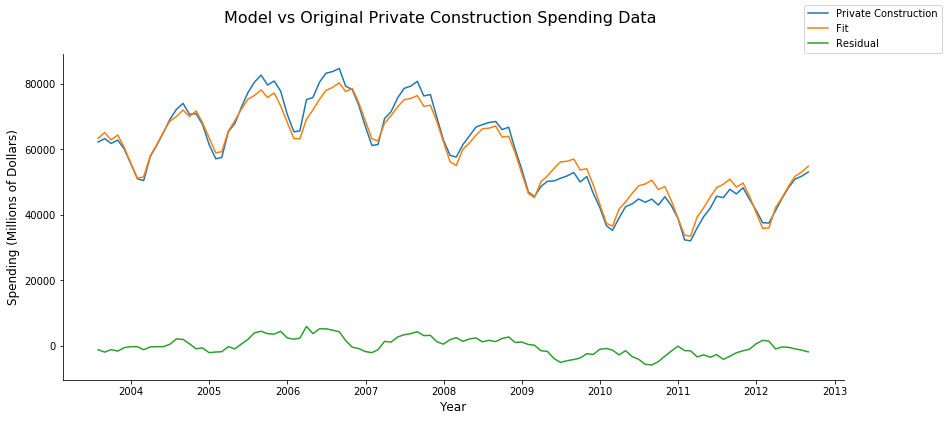

In [34]:
fig,ax = plt.subplots()
ax.plot(df['Private Construction'],label='Private Construction')
ax.plot(df['fit'],label='Fit')
ax.plot(df['R2Private'],label='Residual')
ax.set_xlabel('Year', fontsize = '12')
ax.set_ylabel('Spending (Millions of Dollars)', fontsize = '12')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
fig.suptitle('Model vs Original Private Construction Spending Data', fontsize = '16')
fig.set_size_inches(14,6)

## Step 2: Public Construction Analysis

In [35]:
#Read in the data and view first 5 rows
dfPB = pd.read_csv('ConstructionTimeSeriesDataV2.csv')
dfPB.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


In [36]:
def sqErrPB(row):
    return (row['Public Construction'] - row['MovAvgPB']) **2

dfPB['MovAvgPB'] = np.NaN
dfPB['sqErrPB'] = np.NaN

#Create date/time index to calculate moving average for analysis
dfPB.index = pd.date_range(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(dfPB['Public Construction']))

window = 36
window = window - window % 2
#Use a for loop to compute the moving average with above window size
for i in range(int(window/2),dfPB.shape[0]-int(window/2)):
    dfPB.loc[dfPB.index[i],'MovAvgPB'] = (0.5*dfPB.iloc[i - int(window/2)]['Public Construction'] + dfPB.iloc[i - int(window/2)+1:i + int(window/2)]['Public Construction'].sum() + 0.5*dfPB.iloc[i + int(window/2)]['Public Construction'])/float(window)

#Compute squared error
dfPB['sqErrPB'] = (dfPB['Public Construction'] - dfPB['MovAvgPB'])**2
dfPB['CumSqErrPB'] = dfPB['sqErrPB'].cumsum(axis = 0)

# Remove na values from moving average
dfPB.dropna(how='any',inplace=True)

print('Cumulative Squared Error: ', sum(dfPB['sqErrPB']))
print('Average Squared Error per Month: ',sum(dfPB['sqErrPB'])/len(dfPB))

Cumulative Squared Error:  1493970291.1101463
Average Squared Error per Month:  13581548.10100133


- Compute residual public construction value ($R1Public$) relative to moving average and as % of residual ($R1 Error$)

In [37]:
dfPB['R1'] = dfPB['Public Construction'] - dfPB['MovAvgPB']
dfPB['R1Error'] = abs((dfPB['Public Construction'] - dfPB['R1'])/dfPB['Public Construction'])
dfPB.style.format({
    'MovAvgPB': '{:.1f}'.format,
    'sqErrPB': '{:,.1f}'.format,
    'CumSqErrPB': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvgPB,sqErrPB,CumSqErrPB,R1,R1Error
2003-07-31 00:00:00,19,Jul-03,82971,62216,20755,18050.5,"7,314,395.4","7,314,395.4","2,704.5",0.870
2003-08-31 00:00:00,20,Aug-03,85191,63234,21957,18058.0,"15,202,201.0","22,516,596.4","3,899.0",0.822
2003-09-30 00:00:00,21,Sep-03,83841,61767,22075,18084.9,"15,920,765.0","38,437,361.4","3,990.1",0.819
2003-10-31 00:00:00,22,Oct-03,83133,62813,20321,18126.2,"4,817,354.3","43,254,715.7","2,194.8",0.892
2003-11-30 00:00:00,23,Nov-03,77915,60115,17801,18170.0,"136,161.0","43,390,876.7",-369.0,1.021
2003-12-31 00:00:00,24,Dec-03,71050,55584,15466,18235.5,"7,670,130.2","51,061,007.0","-2,769.5",1.179
2004-01-31 00:00:00,25,Jan-04,64934,50975,13959,18309.2,"18,923,950.0","69,984,957.0","-4,350.2",1.312
2004-02-29 00:00:00,26,Feb-04,64138,50449,13689,18377.0,"21,976,953.3","91,961,910.3","-4,688.0",1.342
2004-03-31 00:00:00,27,Mar-04,73238,57796,15443,18444.6,"9,009,669.3","100,971,579.6","-3,001.6",1.194
2004-04-30 00:00:00,28,Apr-04,78354,61177,17177,18502.0,"1,755,625.0","102,727,204.6","-1,325.0",1.077


In [38]:
maxCorrPB = 0.0
periodPB = np.NaN
for i in range(1,37):
    corrPB = dfPB['R1'].autocorr(lag=i)
    
    if corrPB > maxCorrPB:
        maxCorrPB = corrPB
        periodPB = i
print('period = ',periodPB,'     Maximum Correlation = ',maxCorrPB)

period =  12      Maximum Correlation =  0.9802446550357118


- Based on the above calculations for Private Construction, we can use the same periord value of 12 to compute cyclicality component.
- Compute a column named $R2Public$ that shows the error of model
- Compute a column named $R2ErrorPublic$ that shows $R2Public$ relative to original data series

In [39]:
#Create an empty column for the cyclicality component data
cycleLenPB = periodPB
dfPB['C_PB'] = np.NaN  
numCyclesPB = int(len(dfPB)/cycleLenPB + 0.5)
cyclesPB = [dfPB.iloc[range(i*periodPB,min((i+1)*periodPB,len(dfPB)))]['R1'] for i in range(numCyclesPB)]
ptsInCyclesPB = [dfPB.iloc[range(i,len(dfPB['R1']),periodPB)]['R1'].tolist() for i in range(periodPB)]
avgPB = [sum(pts)/len(pts) for pts in ptsInCyclesPB]

for i in range(len(dfPB)):
    dfPB.loc[dfPB.index[i], 'C_PB'] = avgPB[i % cycleLenPB]

#Compute required error columns
dfPB['R2Public'] = dfPB['R1'] - dfPB['C_PB']
dfPB['R2ErrorPublic'] = abs(dfPB['R2Public']/dfPB['Public Construction'])

#Compute model fit for use in later graph
dfPB['fit'] = dfPB['MovAvgPB'] + dfPB['C_PB']

print('R2Public: ', sum(abs(dfPB['R2Public'])))
print('R2ErrorPublic: ', sum(dfPB['R2ErrorPublic'])/len(dfPB))
print(dfPB)

R2Public:  62925.76141975312
R2ErrorPublic:  0.024999478035219624
            Month Month-Year  Total Construction  Private Construction  \
2003-07-31     19     Jul-03               82971                 62216   
2003-08-31     20     Aug-03               85191                 63234   
2003-09-30     21     Sep-03               83841                 61767   
2003-10-31     22     Oct-03               83133                 62813   
2003-11-30     23     Nov-03               77915                 60115   
2003-12-31     24     Dec-03               71050                 55584   
2004-01-31     25     Jan-04               64934                 50975   
2004-02-29     26     Feb-04               64138                 50449   
2004-03-31     27     Mar-04               73238                 57796   
2004-04-30     28     Apr-04               78354                 61177   
2004-05-31     29     May-04               83736                 65027   
2004-06-30     30     Jun-04               899

- Display final graph of model vs the orignal data set

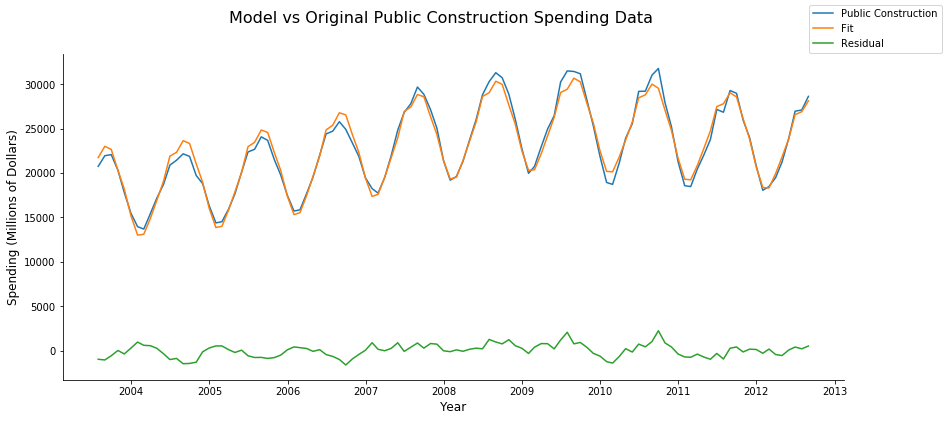

In [40]:
fig,ax = plt.subplots()
ax.plot(dfPB['Public Construction'],label='Public Construction')
ax.plot(dfPB['fit'],label='Fit')
ax.plot(dfPB['R2Public'],label='Residual')
ax.set_xlabel('Year', fontsize = '12')
ax.set_ylabel('Spending (Millions of Dollars)', fontsize = '12')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
fig.suptitle('Model vs Original Public Construction Spending Data', fontsize = '16')
fig.set_size_inches(14,6)